<a href="https://colab.research.google.com/github/Pisarenkova/KT_2025/blob/main/fenics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорт библиотек

In [ ]:
!apt-get install -y software-properties-common
!add-apt-repository -y ppa:fenics-packages/fenics
!apt-get update
!apt-get install -y fenics

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
software-properties-common is already the newest version (0.99.22.9).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.
Repository: 'deb https://ppa.launchpadcontent.net/fenics-packages/fenics/ubuntu/ jammy main'
Description:
This PPA provides packages for the FEniCS project (https://fenicsproject.org).
More info: https://launchpad.net/~fenics-packages/+archive/ubuntu/fenics
Adding repository.
Adding deb entry to /etc/apt/sources.list.d/fenics-packages-ubuntu-fenics-jammy.list
Adding disabled deb-src entry to /etc/apt/sources.list.d/fenics-packages-ubuntu-fenics-jammy.list
Adding key to /etc/apt/trusted.gpg.d/fenics-packages-ubuntu-fenics.gpg with fingerprint 6C1DA1C0EC4B649179C1C7437C3297BD11D01687
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:3 https://develop

In [ ]:
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-release-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

--2025-03-20 10:42:42--  https://fem-on-colab.github.io/releases/fenics-install-release-real.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4180 (4.1K) [application/x-sh]
Saving to: ‘/tmp/fenics-install.sh’

/tmp/fenics-install 100%[===================>]   4.08K  --.-KB/s    in 0s      

2025-03-20 10:42:42 (29.7 MB/s) - ‘/tmp/fenics-install.sh’ saved [4180/4180]

+ INSTALL_PREFIX=/usr/local
++ echo /usr/local
++ awk -F/ '{print NF-1}'
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FENICS_INSTALLED=/usr/local/share/fem-on-colab/fenics.installed
+ [[ ! -f /usr/local/share/fem-on-colab/fenics.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/1f33a7ab/releases/pybi

# Решение задачи

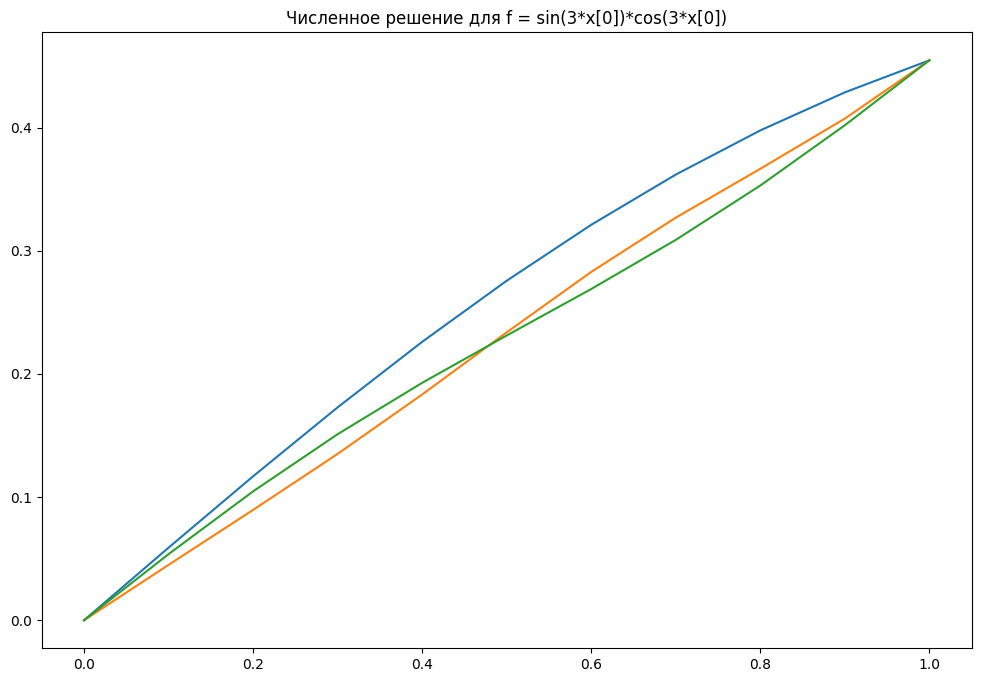

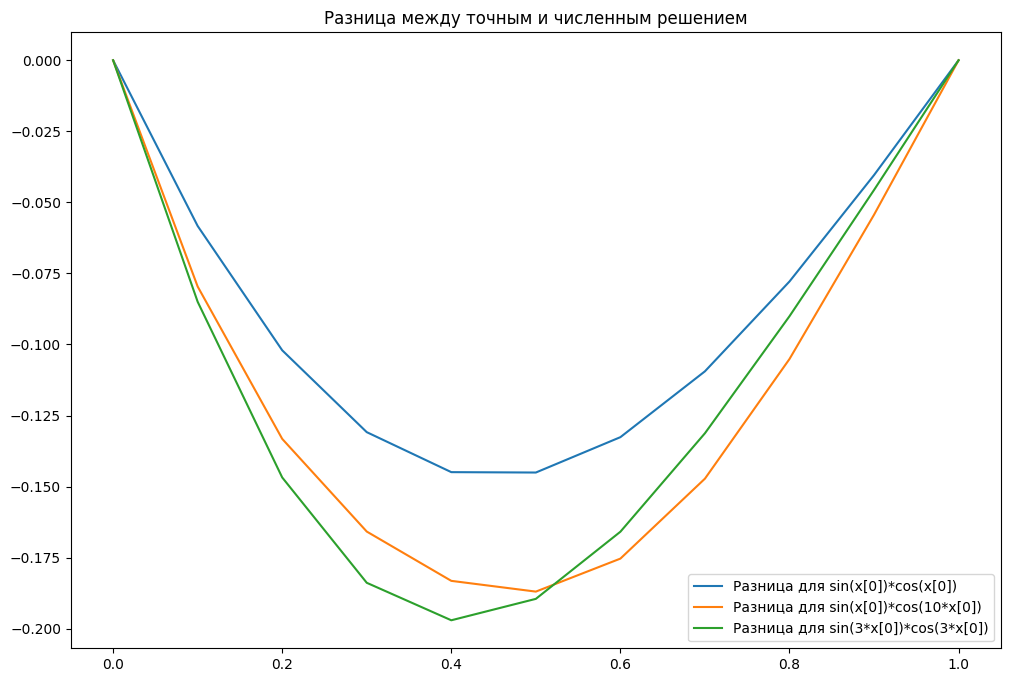

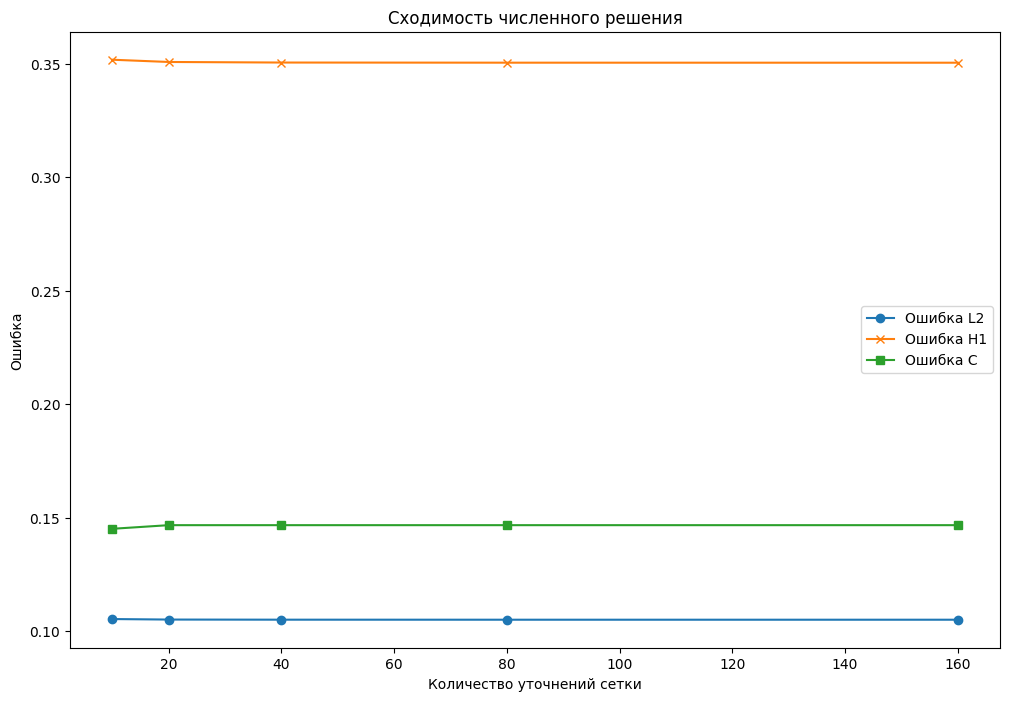

In [ ]:
from fenics import *
import matplotlib.pyplot as plt
import numpy as np

# Функция для решения краевой задачи Пуассона
def solve_poisson(f, degree=1, mesh_refinements=10):
    # Определяем сетку
    mesh = UnitIntervalMesh(mesh_refinements)

    # Определяем функцию пространства
    V = FunctionSpace(mesh, 'P', degree)

    # Граничные условия
    u_D = Expression('sin(x[0])*cos(x[0])', degree=2)
    bc = DirichletBC(V, u_D, 'on_boundary')

    # Определяем форму уравнения Пуассона
    u = TrialFunction(V)
    v = TestFunction(V)
    f_expr = f
    a = dot(grad(u), grad(v)) * dx
    L = f_expr * v * dx

    # Решение задачи
    u = Function(V)
    solve(a == L, u, bc)

    return u, mesh

# Определяем различные функции источников для разных частот
functions = [
    'sin(x[0])*cos(x[0])',       # Минимальная частота
    'sin(x[0])*cos(10*x[0])',     # Максимальная частота
    'sin(3*x[0])*cos(3*x[0])'     # Промежуточная частота
]

# Решение для каждой функции
solutions = []
for f_expr in functions:
    u, mesh = solve_poisson(Expression(f_expr, degree=2))
    solutions.append((u, mesh, f_expr))

# Визуализация численных решений
plt.figure(figsize=(12, 8))
for i, (u, mesh, f_expr) in enumerate(solutions):
    plot(u)
    plt.title(f"Численное решение для f = {f_expr}")

plt.show()

# Визуализация разницы между численным и точным решением
plt.figure(figsize=(12, 8))
for i, (u, mesh, f_expr) in enumerate(solutions):
    # Интерполируем точное решение в пространство функций
    exact_solution = Expression('sin(x[0])*cos(x[0])', degree=2)
    u_exact = interpolate(exact_solution, u.function_space())  # Интерполяция

    # Разница между численным и точным решением
    diff = u.vector().get_local() - u_exact.vector().get_local()

    # Визуализация разницы
    plt.plot(mesh.coordinates(), diff, label=f"Разница для {f_expr}")

plt.legend()
plt.title("Разница между точным и численным решением")
plt.show()

# Функция для оценки норм
def compute_errors(u, exact_solution, mesh):
    # Норма L2
    L2_error = errornorm(exact_solution, u, norm_type='L2', degree_rise=3)

    # Норма H1
    H1_error = errornorm(exact_solution, u, norm_type='H1', degree_rise=3)

    # Норма C
    u_exact_interpolated = interpolate(exact_solution, u.function_space())  # Интерполяция
    C_error = np.max(np.abs(u.vector().get_local() - u_exact_interpolated.vector().get_local()))

    return L2_error, H1_error, C_error

# Оценка ошибок для разных разрешений
mesh_refinements = [10, 20, 40, 80, 160]
L2_errors, H1_errors, C_errors = [], [], []

for refinements in mesh_refinements:
    u, mesh = solve_poisson(Expression('sin(x[0])*cos(x[0])', degree=2), mesh_refinements=refinements)
    exact_solution = Expression('sin(x[0])*cos(x[0])', degree=2)

    L2_error, H1_error, C_error = compute_errors(u, exact_solution, mesh)

    L2_errors.append(L2_error)
    H1_errors.append(H1_error)
    C_errors.append(C_error)

# Построение графиков ошибок
plt.figure(figsize=(12, 8))
plt.plot(mesh_refinements, L2_errors, label="Ошибка L2", marker='o')
plt.plot(mesh_refinements, H1_errors, label="Ошибка H1", marker='x')
plt.plot(mesh_refinements, C_errors, label="Ошибка C", marker='s')
plt.xlabel('Количество уточнений сетки')
plt.ylabel('Ошибка')
plt.legend()
plt.title('Сходимость численного решения')
plt.show()